In [1]:
"""
In this project, I'll try to clustering this dataset using two methods (K-Means and Hierarchical clustering (Agglomerative)).
"""

%pip install kneed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from kneed import KneeLocator

import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


In [ ]:
data = pd.read_csv(
    "/kaggle/input/health-and-lifestyle-dataset/health_lifestyle_dataset.csv"
)

# K-Means Clustering

In [3]:
data

,id,age,gender,bmi,daily_steps,sleep_hours,water_intake_l,calories_consumed,smoker,alcohol,resting_hr,systolic_bp,diastolic_bp,cholesterol,family_history,disease_risk
0,1,56,Male,20.5,4198,3.9,3.4,1602,0,0,97,161,111,240,0,0
1,2,69,Female,33.3,14359,9.0,4.7,2346,0,1,68,116,65,207,0,0
2,3,46,Male,31.6,1817,6.6,4.2,1643,0,1,90,123,99,296,0,0
3,4,32,Female,38.2,15772,3.6,2.0,2460,0,0,71,165,95,175,0,0
4,5,60,Female,33.6,6037,3.8,4.0,3756,0,1,98,139,61,294,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,53,Male,33.1,4726,3.9,2.0,3118,0,1,56,105,76,282,0,0
99996,99997,22,Male,35.1,11554,4.5,3.1,1967,0,0,51,149,77,192,0,0
99997,99998,37,Male,18.9,3924,3.8,1.0,2328,0,0,69,92,117,218,0,0
99998,99999,72,Female,27.8,16110,5.6,0.8,3093,0,0,93,164,72,188,0,0


## Missing value check

In [4]:
data.isnull().sum()

id                   0
age                  0
gender               0
bmi                  0
daily_steps          0
sleep_hours          0
water_intake_l       0
calories_consumed    0
smoker               0
alcohol              0
resting_hr           0
systolic_bp          0
diastolic_bp         0
cholesterol          0
family_history       0
disease_risk         0
dtype: int64

## Outlier check

In [ ]:
NUM_COLS = data.select_dtypes(include="number").columns.tolist()


def outlier_summary_df(df, cols=None, z_thresh=3.0):
    if cols is None:
        cols = df.select_dtypes(include="number").columns.tolist()
    rows = []
    for c in cols:
        s = pd.to_numeric(df[c], errors="coerce")
        n = s.notna().sum()
        if n == 0:
            rows.append(
                {
                    "col": c,
                    "n": 0,
                    "pct_missing": 100.0,
                    "iqr_outliers_n": 0,
                    "iqr_outliers_pct": 0.0,
                    "z_outliers_n": 0,
                    "z_outliers_pct": 0.0,
                    "q1": np.nan,
                    "q3": np.nan,
                    "iqr": np.nan,
                    "lf": np.nan,
                    "uf": np.nan,
                    "mean": np.nan,
                    "std": np.nan,
                }
            )
            continue

        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        lf, uf = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        iqr_mask = (s < lf) | (s > uf)
        iqr_n = int(iqr_mask.sum())

        mean, std = s.mean(), s.std(ddof=0)
        if std > 0:
            z = (s - mean) / std
            z_mask = z.abs() > z_thresh
            z_n = int(z_mask.sum())
        else:
            z_n = 0

        rows.append(
            {
                "col": c,
                "n": int(n),
                "pct_missing": float(100 * (1 - n / len(s))),
                "iqr_outliers_n": iqr_n,
                "iqr_outliers_pct": float(100 * iqr_n / max(n, 1)),
                "z_outliers_n": z_n,
                "z_outliers_pct": float(100 * z_n / max(n, 1)),
                "q1": float(q1),
                "q3": float(q3),
                "iqr": float(iqr),
                "lf": float(lf),
                "uf": float(uf),
                "mean": float(mean),
                "std": float(std),
            }
        )
    out = pd.DataFrame(rows)
    out = out.sort_values("iqr_outliers_pct", ascending=False).reset_index(
        drop=True
    )
    return out


summary = outlier_summary_df(data, NUM_COLS, z_thresh=3.0)
summary.head(12)

,col,n,pct_missing,iqr_outliers_n,iqr_outliers_pct,z_outliers_n,z_outliers_pct,q1,q3,iqr,lf,uf,mean,std
0,disease_risk,100000,0.0,24821,24.821,0,0.0,0.00,0.00,0.0,0.00,0.00,0.248210,0.431974
1,smoker,100000,0.0,20094,20.094,0,0.0,0.00,0.00,0.0,0.00,0.00,0.200940,0.400703
2,id,100000,0.0,0,0.000,0,0.0,25000.75,75000.25,49999.5,-49998.50,149999.50,50000.500000,28867.513458
3,age,100000,0.0,0,0.000,0,0.0,33.00,64.00,31.0,-13.50,110.50,48.525990,17.886678
4,bmi,100000,0.0,0,0.000,0,0.0,23.50,34.50,11.0,7.00,51.00,29.024790,6.352634
5,daily_steps,100000,0.0,0,0.000,0,0.0,5729.00,15229.00,9500.0,-8521.00,29479.00,10479.870290,5483.604942
6,sleep_hours,100000,0.0,0,0.000,0,0.0,4.70,8.20,3.5,-0.55,13.45,6.491784,2.021912
7,water_intake_l,100000,0.0,0,0.000,0,0.0,1.60,3.90,2.3,-1.85,7.35,2.751496,1.297331
8,calories_consumed,100000,0.0,0,0.000,0,0.0,1906.00,3299.00,1393.0,-183.50,5388.50,2603.341200,807.284527
9,alcohol,100000,0.0,0,0.000,0,0.0,0.00,1.00,1.0,-1.50,2.50,0.300020,0.458266


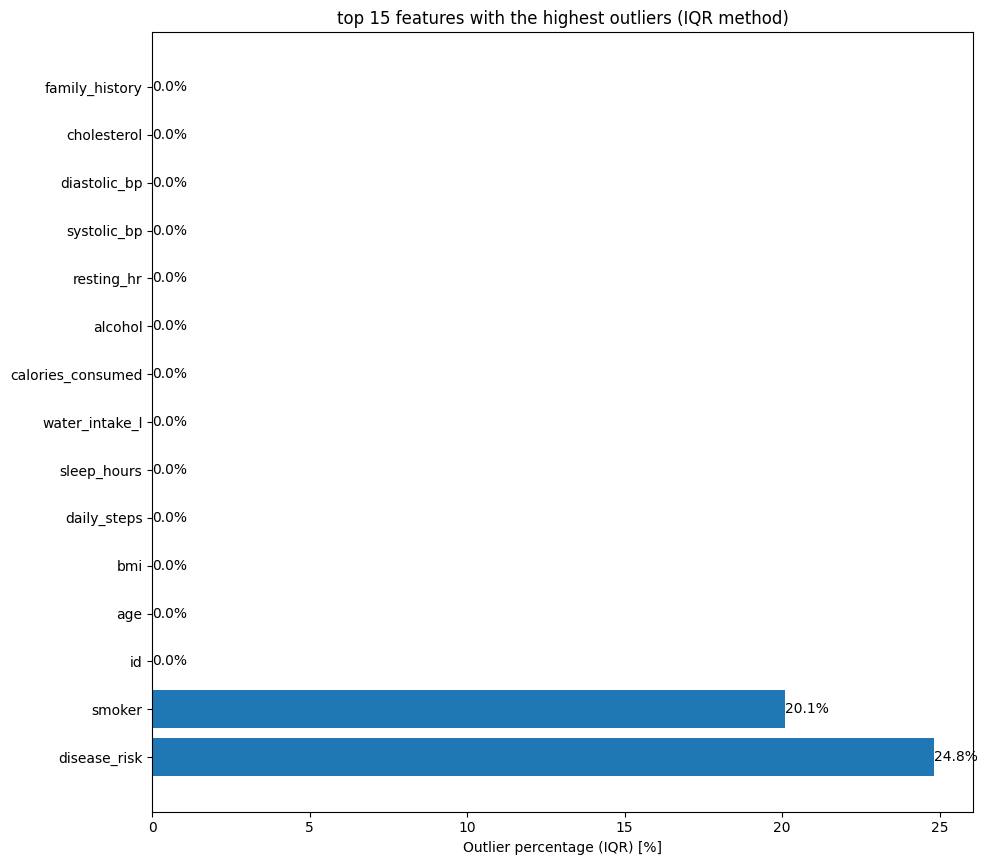

In [ ]:
def plot_outlier_rates(summary_df, top_n=20):
    subset = summary_df.head(top_n)
    plt.figure(figsize=(10, 5 + (0.25 * len(subset))))
    y = np.arange(len(subset))
    plt.barh(y, subset["iqr_outliers_pct"].values)
    plt.yticks(y, subset["col"].values)
    plt.xlabel("Outlier percentage (IQR) [%]")
    plt.title(f"top {top_n} features with the highest outliers (IQR method)")
    for i, v in enumerate(subset["iqr_outliers_pct"].values):
        plt.text(v, i, f"{v:.1f}%", va="center", ha="left")
    plt.tight_layout()
    plt.show()


plot_outlier_rates(summary, top_n=min(20, len(summary)))

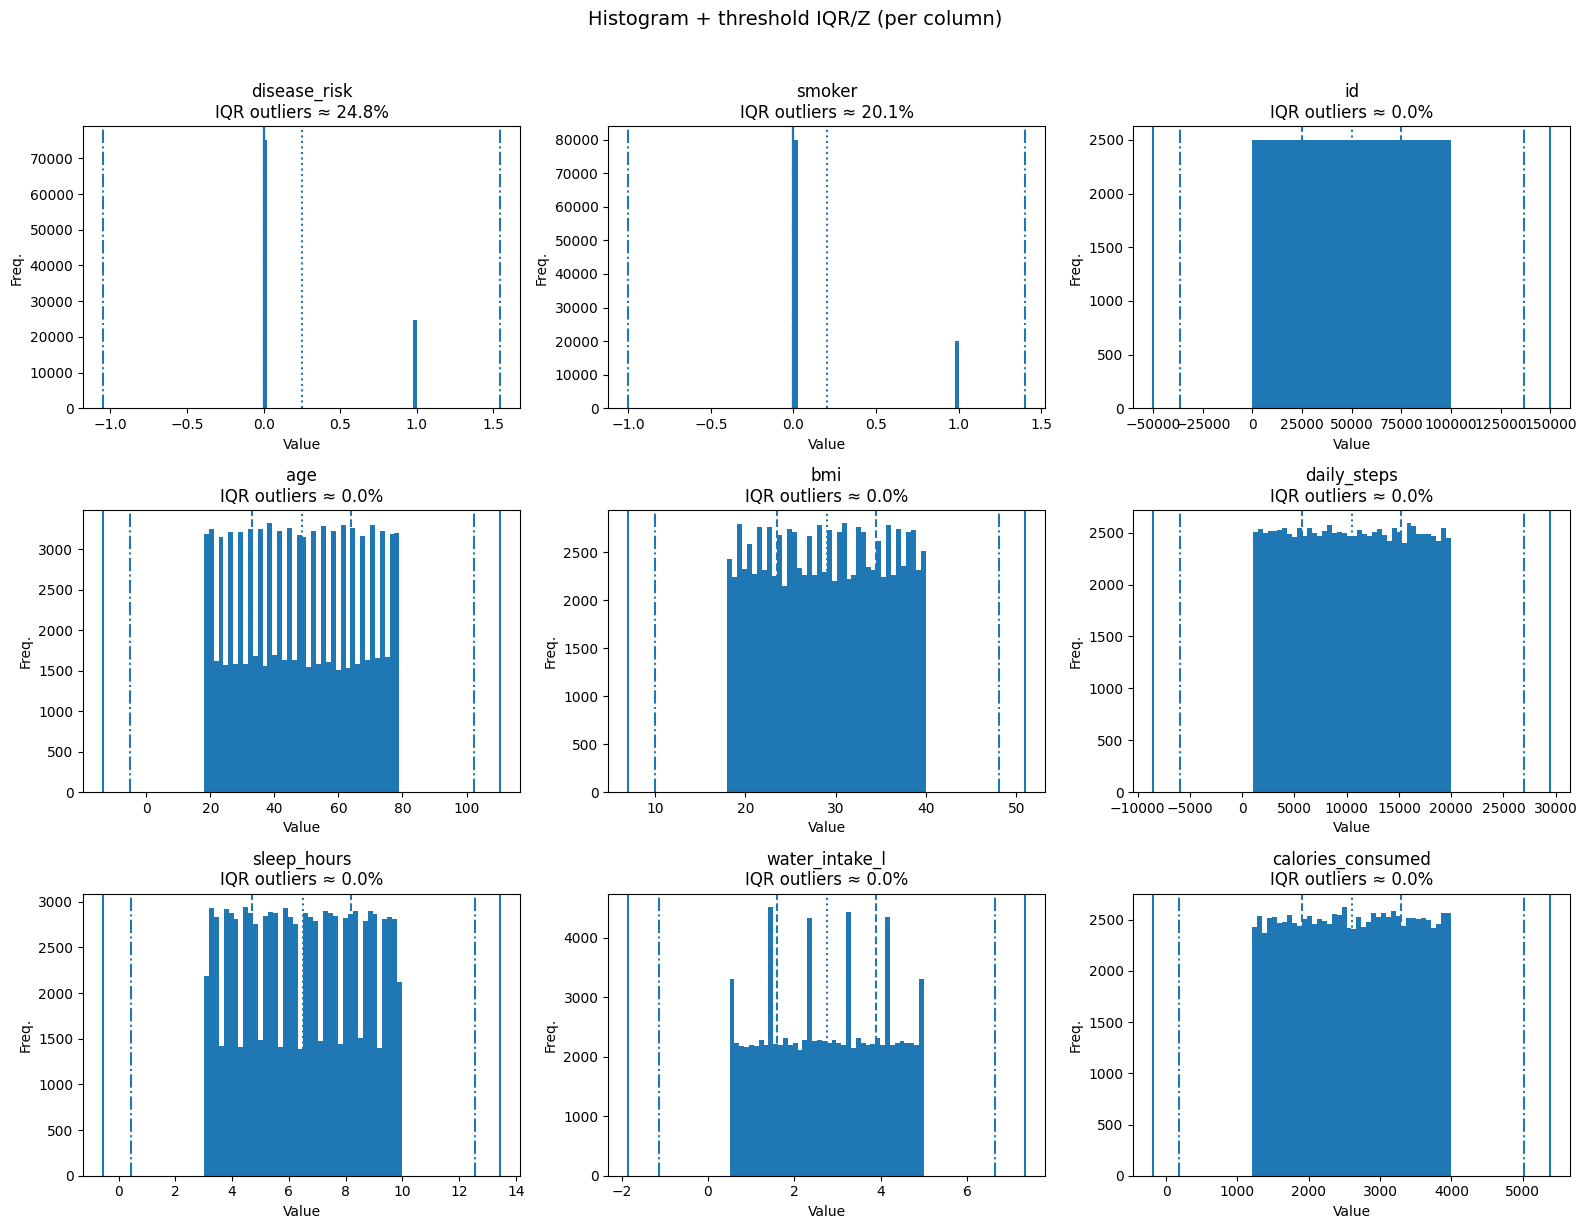

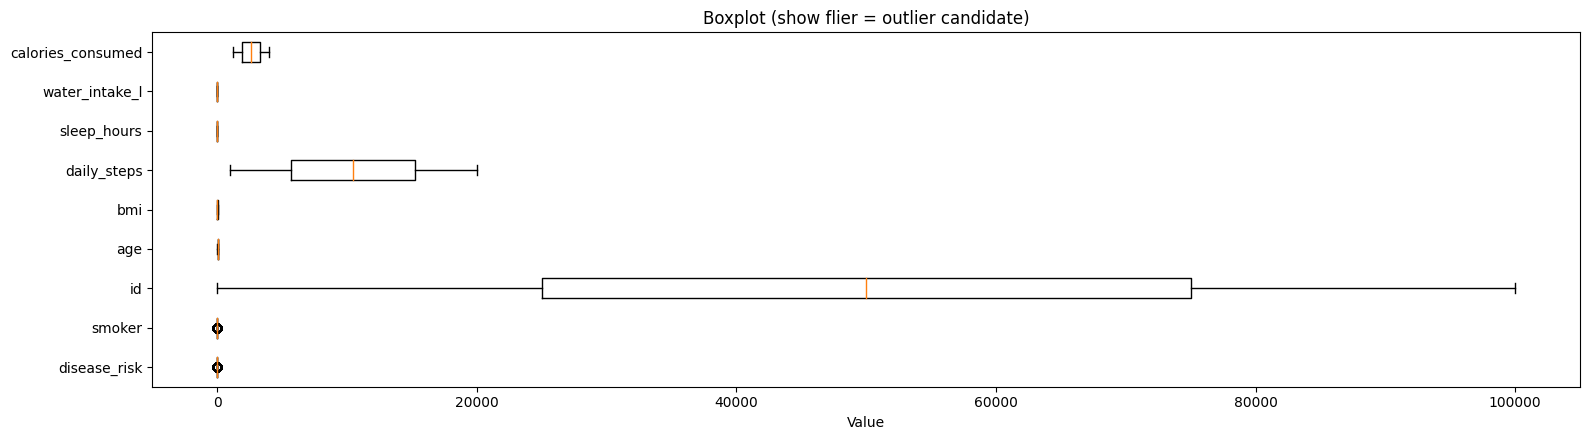

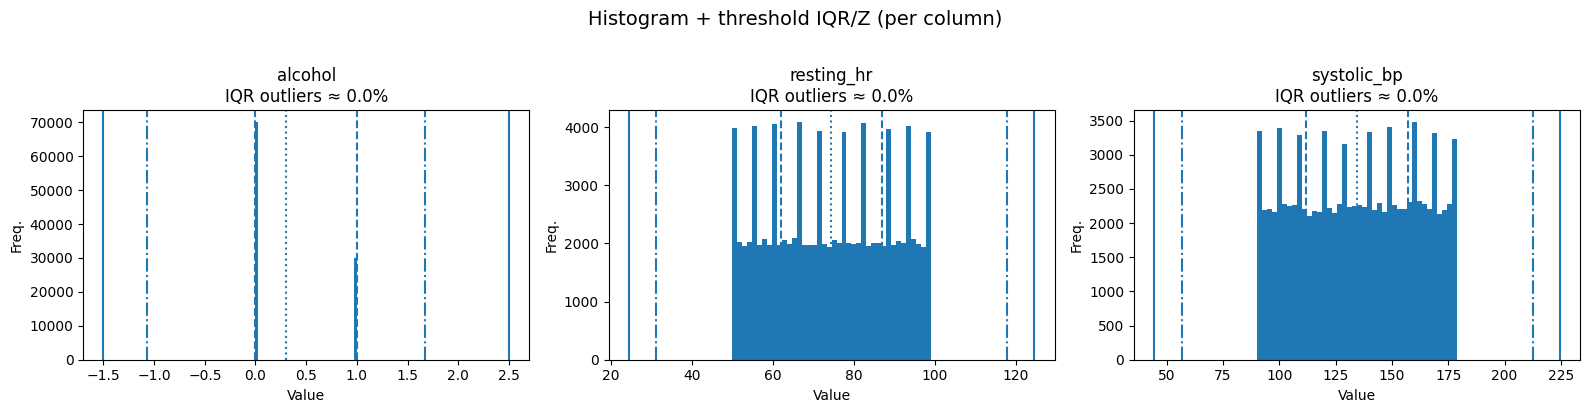

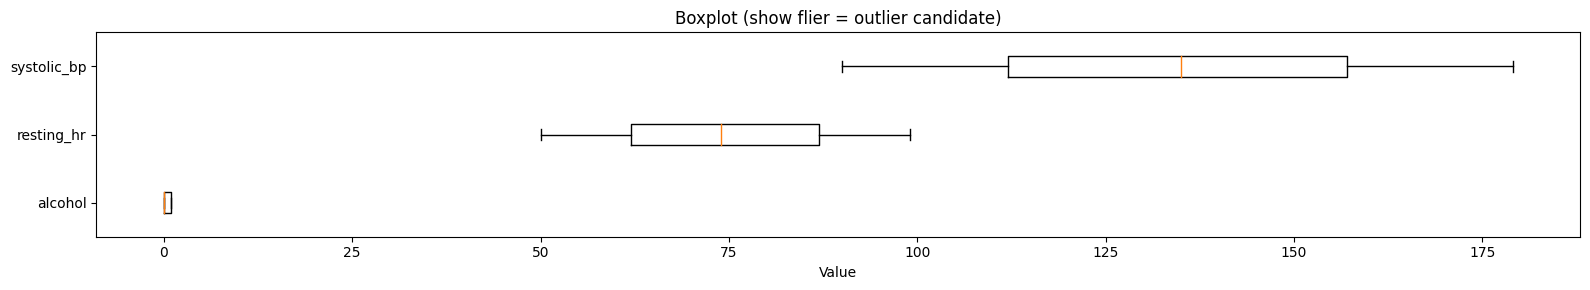

In [ ]:
def plot_distributions_with_thresholds(
    df,
    cols,
    bins=50,
    z_thresh=3.0,
    max_cols_per_page=9,
    sample_for_plot=100_000,
):
    cols = [c for c in cols if c in df.columns]
    if len(df) > sample_for_plot:
        dfp = df.sample(sample_for_plot, random_state=42)
    else:
        dfp = df

    for page_start in range(0, len(cols), max_cols_per_page):
        subset = cols[page_start : page_start + max_cols_per_page]
        n_plots = len(subset)
        n_rows = int(np.ceil(n_plots / 3))
        fig, axes = plt.subplots(n_rows, 3, figsize=(16, 4 * n_rows))
        axes = np.array(axes).reshape(-1)

        for ax, c in zip(axes, subset):
            s = pd.to_numeric(dfp[c], errors="coerce").dropna()
            if s.empty:
                ax.set_title(f"{c} (empty)")
                ax.axis("off")
                continue

            q1, q3 = s.quantile([0.25, 0.75])
            iqr = q3 - q1
            lf, uf = q1 - 1.5 * iqr, q3 + 1.5 * iqr
            mean, std = s.mean(), s.std(ddof=0)
            iqr_pct = 100 * ((s < lf) | (s > uf)).mean()

            ax.hist(s.values, bins=bins)
            ax.set_title(f"{c}\nIQR outliers ≈ {iqr_pct:.1f}%")
            ax.set_ylabel("Freq.")
            ax.set_xlabel("Value")

            ax.axvline(q1, linestyle="--")
            ax.axvline(q3, linestyle="--")
            ax.axvline(lf, linestyle="-")
            ax.axvline(uf, linestyle="-")
            ax.axvline(mean, linestyle=":")

            if std > 0:
                z_l, z_u = mean - z_thresh * std, mean + z_thresh * std
                ax.axvline(z_l, linestyle="-.")
                ax.axvline(z_u, linestyle="-.")

        for ax in axes[n_plots:]:
            ax.axis("off")
        fig.suptitle(
            "Histogram + threshold IQR/Z (per column)", y=1.02, fontsize=14
        )
        plt.tight_layout()
        plt.show()

        fig, axes = plt.subplots(1, 1, figsize=(16, max(3, 0.5 * len(subset))))
        axes.boxplot(
            [
                pd.to_numeric(dfp[c], errors="coerce").dropna().values
                for c in subset
            ],
            vert=False,
            labels=subset,
            showfliers=True,
        )
        axes.set_title("Boxplot (show flier = outlier candidate)")
        axes.set_xlabel("Value")
        plt.tight_layout()
        plt.show()


top_cols = summary["col"].tolist()[: min(12, len(summary))]
plot_distributions_with_thresholds(data, top_cols, bins=40, z_thresh=3.0)

## Drop target and check column type

In [ ]:
df = data.copy()

# Drop column
cols_to_drop = ["id", "disease_risk"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# Column type identification
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(
    include=["object", "category", "bool"]
).columns.tolist()

print("Numerical:", num_cols)
print("Categorical:", cat_cols)

Numerical: ['age', 'bmi', 'daily_steps', 'sleep_hours', 'water_intake_l', 'calories_consumed', 'smoker', 'alcohol', 'resting_hr', 'systolic_bp', 'diastolic_bp', 'cholesterol', 'family_history']
Categorical: ['gender']


## Encoder and normalization data

In [ ]:
num_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
    ]
)

cat_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
)

X_pre = preprocess.fit_transform(df)
display(X_pre.shape)
display(X_pre)

(100000, 15)

array([[ 0.25806452, -0.77272727, -0.66      , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.67741935,  0.39090909,  0.40957895, ...,  0.        ,
         1.        ,  0.        ],
       [-0.06451613,  0.23636364, -0.91063158, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.35483871, -0.91818182, -0.68884211, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.77419355, -0.10909091,  0.59389474, ...,  0.        ,
         1.        ,  0.        ],
       [-0.35483871,  0.58181818, -0.23642105, ...,  0.        ,
         0.        ,  1.        ]])

## Search for the best k-values

In [ ]:
# Search for the best k values
k_values = list(range(2, 12))
results = []

models = {}
for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_pre)
    labels = km.labels_

    sil = silhouette_score(X_pre, labels, metric="euclidean")

    results.append({"k": k, "wcss": km.inertia_, "silhouette": sil})
    models[k] = km

scores_df = pd.DataFrame(results)
display(scores_df)

,k,wcss,silhouette
0,2,387988.232934,0.114045
1,3,375311.001016,0.077463
2,4,362811.368990,0.064261
3,5,355106.505426,0.058868
4,6,347526.928737,0.054247
5,7,341387.766145,0.054624
6,8,335442.385259,0.054456
7,9,330907.426932,0.054112
8,10,326164.563452,0.053883
9,11,322364.938871,0.053781


## Visualization of evaluation score

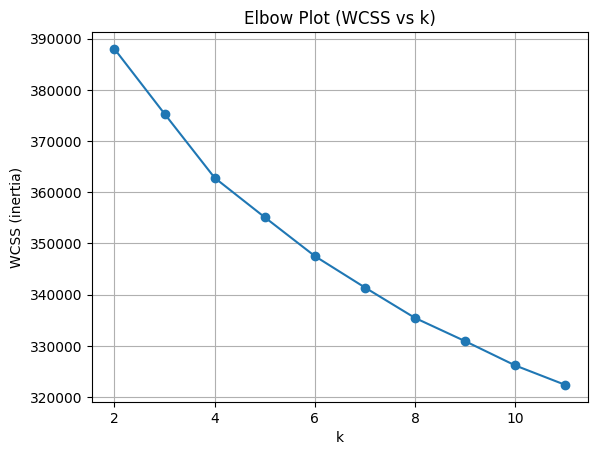

In [ ]:
# Elbow (WCSS) visualization
plt.figure()
plt.plot(scores_df["k"], scores_df["wcss"], marker="o")
plt.title("Elbow Plot (WCSS vs k)")
plt.xlabel("k")
plt.ylabel("WCSS (inertia)")
plt.grid(True)
plt.show()

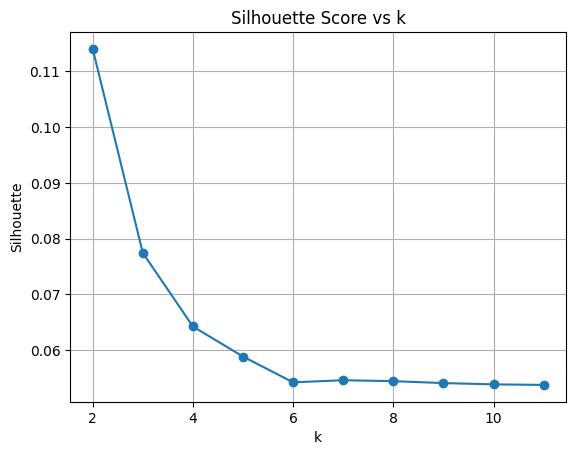

In [ ]:
# Silhouette score visualization
plt.figure()
plt.plot(scores_df["k"], scores_df["silhouette"], marker="o")
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.grid(True)
plt.show()

## Detail for each cluster

In [ ]:
best_model = models[2]
labels = best_model.labels_

df_with_cluster = df.copy()
df_with_cluster["cluster"] = labels

print(df_with_cluster["cluster"].value_counts().sort_index())

cluster
0    49868
1    50132
Name: count, dtype: int64


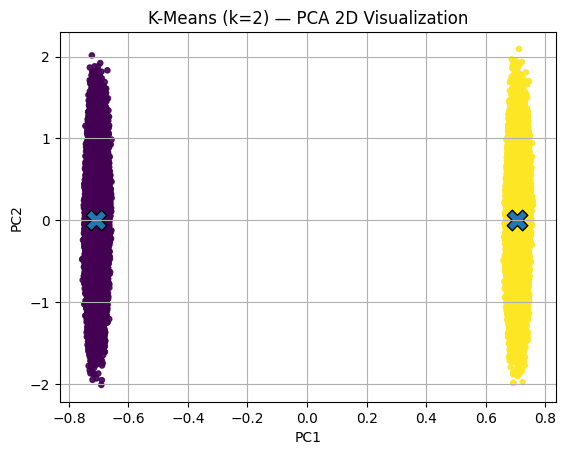

In [ ]:
# 2D PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_pre)

centers_pca = pca.transform(best_model.cluster_centers_)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=14, alpha=0.9)
plt.scatter(
    centers_pca[:, 0], centers_pca[:, 1], marker="X", s=220, edgecolors="k"
)
plt.title(f"K-Means (k=2) — PCA 2D Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# Hierarchical Clustering

## Sampling Data

In [15]:
data = data.sample(n=10_000)

## Drop Target and check column typw

In [ ]:
df = data.copy()

# Drop column
cols_to_drop = ["id", "disease_risk"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# Column type identification
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(
    include=["object", "category", "bool"]
).columns.tolist()

print("Numerical:", num_cols)
print("Categorical:", cat_cols)

Numerical: ['age', 'bmi', 'daily_steps', 'sleep_hours', 'water_intake_l', 'calories_consumed', 'smoker', 'alcohol', 'resting_hr', 'systolic_bp', 'diastolic_bp', 'cholesterol', 'family_history']
Categorical: ['gender']


## Encoder categorical and normalization data

In [ ]:
num_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
    ]
)

cat_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
)

X_pre = preprocess.fit_transform(df)
display(X_pre.shape)
display(X_pre)

(10000, 15)

array([[ 0.80645161,  0.81081081,  0.94418629, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.        , -0.85585586, -0.59593797, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.06451613, -0.44144144,  0.37894847, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.03225806,  0.07207207, -0.72040934, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.67741935, -0.5045045 , -0.0894899 , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.41935484, -0.9009009 , -0.8936459 , ...,  0.        ,
         1.        ,  0.        ]])

## Search for the best k-values

In [ ]:
def within_sse(X, labels):
    sse = 0.0
    for c in np.unique(labels):
        Xi = X[labels == c]
        mu = Xi.mean(axis=0)
        sse += ((Xi - mu) ** 2).sum()
    return float(sse)


def run_hc_sweep(X, k_values, linkages=("ward", "average", "complete")):
    rows, models = [], {}
    for link in linkages:
        for k in k_values:
            if link == "ward":
                model = AgglomerativeClustering(n_clusters=k, linkage="ward")
            else:
                model = AgglomerativeClustering(
                    n_clusters=k, linkage=link, metric="euclidean"
                )
            labels = model.fit_predict(X)
            sil = silhouette_score(X, labels, metric="euclidean")
            dbi = davies_bouldin_score(X, labels)
            ch = calinski_harabasz_score(X, labels)
            sse = within_sse(X, labels)
            rows.append(
                {
                    "linkage": link,
                    "k": k,
                    "silhouette": sil,
                    "dbi": dbi,
                    "ch": ch,
                    "sse": sse,
                }
            )
            models[(link, k)] = model
    return pd.DataFrame(rows), models


k_values = list(range(2, 22))
hc_scores, hc_models = run_hc_sweep(X_pre, k_values)


def k_by_kneedle(
    df_link, x_col="k", y_col="sse", curve="convex", direction="decreasing"
):
    df_link = df_link.sort_values(x_col)
    ks = df_link[x_col].values
    ys = df_link[y_col].values
    kl = KneeLocator(ks, ys, curve=curve, direction=direction)
    if kl.knee is None:
        return None
    return int(kl.knee)


best_k = {}
for link in hc_scores["linkage"].unique():
    sub = hc_scores[hc_scores["linkage"] == link]

    k_sse = k_by_kneedle(
        sub, y_col="sse", curve="convex", direction="decreasing"
    )

    k_dbi = k_by_kneedle(
        sub, y_col="dbi", curve="convex", direction="decreasing"
    )

    if k_sse is None and k_dbi is None:
        k_alt = int(sub.loc[sub["dbi"].idxmin(), "k"])
    else:
        candidates = [k for k in [k_sse, k_dbi] if k is not None]
        k_alt = (
            int(np.median(candidates))
            if candidates
            else int(sub.loc[sub["dbi"].idxmin(), "k"])
        )

    best_k[link] = {"k_sse": k_sse, "k_dbi": k_dbi, "k_final": k_alt}

best_k

{'ward': {'k_sse': 9, 'k_dbi': 2, 'k_final': 5},
 'average': {'k_sse': 2, 'k_dbi': 2, 'k_final': 2},
 'complete': {'k_sse': 15, 'k_dbi': 2, 'k_final': 8}}

In [ ]:
picks = [("ward", 5), ("average", 2), ("complete", 9)]
rows = []
for link, k in picks:
    mdl = hc_models[(link, k)]
    labels = mdl.fit_predict(X_pre)
    cnts = np.bincount(labels)
    rows.append(
        {
            "linkage": link,
            "k": k,
            "sizes": cnts.tolist(),
            "silhouette": silhouette_score(X_pre, labels),
            "dbi": davies_bouldin_score(X_pre, labels),
            "ch": calinski_harabasz_score(X_pre, labels),
        }
    )
pd.DataFrame(rows)

,linkage,k,sizes,silhouette,dbi,ch
0,ward,5,"[2827, 2119, 2336, 1298, 1420]",0.018853,5.794117,420.317456
1,average,2,"[9998, 2]",0.134852,1.073659,3.190943
2,complete,9,"[1566, 1885, 1777, 473, 557, 813, 809, 890, 1230]",-0.005198,5.191988,191.205448


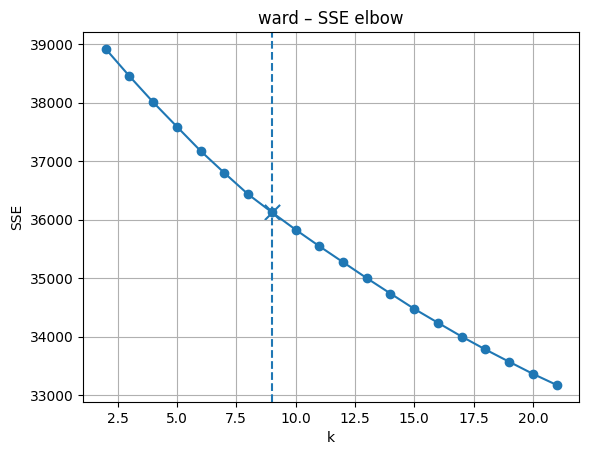

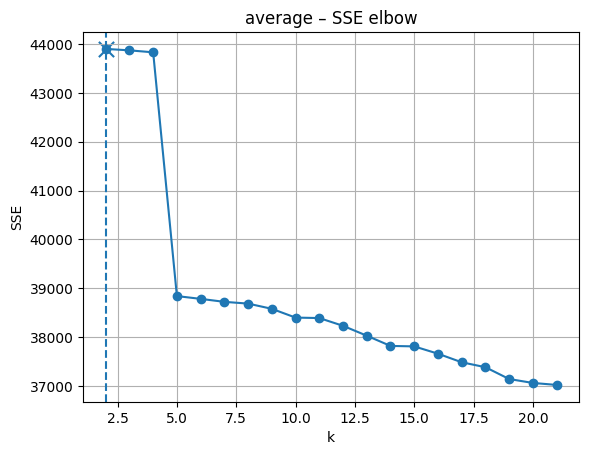

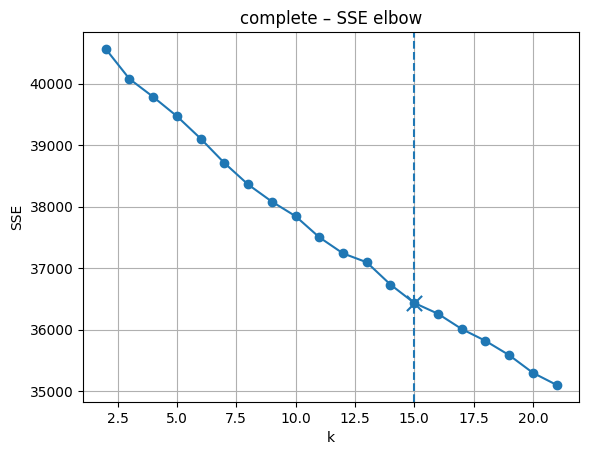

In [ ]:
def plot_elbow(df_link, metric="sse", title=None):
    df_link = df_link.sort_values("k")
    ks, ys = df_link["k"].values, df_link[metric].values
    kl = KneeLocator(ks, ys, curve="convex", direction="decreasing")
    plt.figure()
    plt.plot(ks, ys, marker="o")
    if kl.knee is not None:
        plt.axvline(kl.knee, linestyle="--")
        plt.scatter(
            [kl.knee],
            [df_link[df_link["k"] == kl.knee][metric].values[0]],
            s=120,
            marker="x",
        )
    plt.xlabel("k")
    plt.ylabel(metric.upper())
    plt.title(title or f"Elbow on {metric.upper()}")
    plt.grid(True)
    plt.show()


for link in hc_scores["linkage"].unique():
    plot_elbow(
        hc_scores[hc_scores["linkage"] == link],
        metric="sse",
        title=f"{link} – SSE elbow",
    )

## Detail of cluster

In [ ]:
best_link = "average"
best_k = 2

best_model = hc_models[(best_link, best_k)]
labels = best_model.fit_predict(X_pre)

df_hc = df.copy()
df_hc["cluster"] = labels

print(df_hc["cluster"].value_counts().sort_index())

cluster
0    9998
1       2
Name: count, dtype: int64


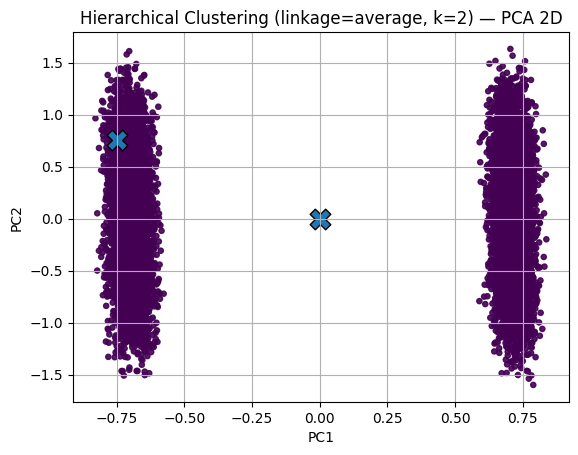

,age,bmi,daily_steps,sleep_hours,water_intake_l,calories_consumed,smoker,alcohol,resting_hr,systolic_bp,diastolic_bp,cholesterol,family_history
cluster,,,,,,,,,,,,,
0,48.33,29.03,10456.93,6.5,2.76,2596.15,0.2,0.3,74.38,134.76,89.19,224.77,0.3
1,19.00,20.35,16809.00,4.1,4.10,1398.00,1.0,0.5,92.50,159.50,75.00,157.50,1.0


In [ ]:
# PCA 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_pre)

centers = np.vstack(
    [X_pre[labels == c].mean(axis=0) for c in sorted(np.unique(labels))]
)
centers_pca = pca.transform(centers)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=14, alpha=0.9)
plt.scatter(
    centers_pca[:, 0], centers_pca[:, 1], marker="X", s=220, edgecolors="k"
)
plt.title(
    f"Hierarchical Clustering (linkage={best_link}, k={best_k}) — PCA 2D"
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

profile = df_hc.groupby("cluster").mean(numeric_only=True).round(2)
display(profile)

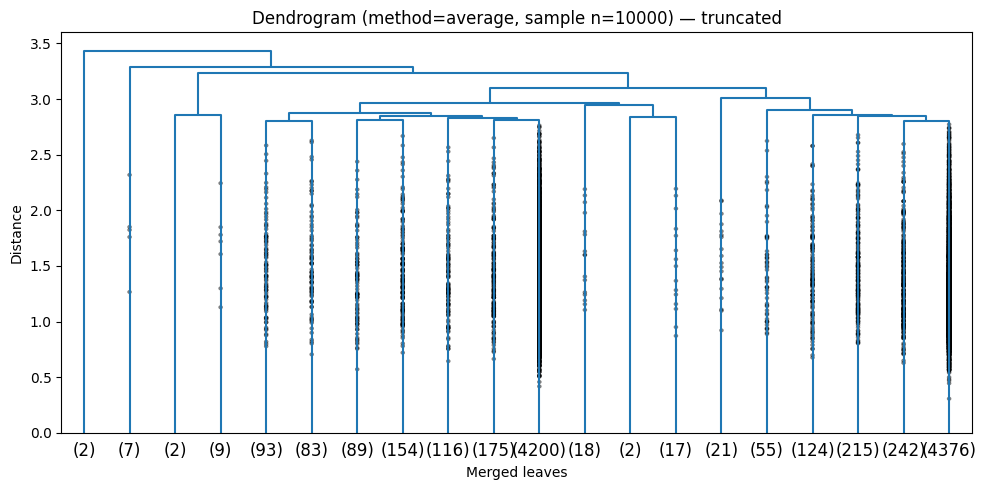

In [ ]:
rng = np.random.RandomState(42)
n = X_pre.shape[0]
take = min(10_000, n)
idx = rng.choice(n, size=take, replace=False)
X_small = X_pre[idx]

# linkage method (best link)
method = best_link
Z = sch.linkage(X_small, method=method)  # default using Euclidean

plt.figure(figsize=(10, 5))
sch.dendrogram(
    Z, truncate_mode="lastp", p=20, show_leaf_counts=True, show_contracted=True
)
plt.title(f"Dendrogram (method={method}, sample n={take}) — truncated")
plt.xlabel("Merged leaves")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()